Задача
В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. 
Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента. 
На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных.

Вам необходимо:
Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

Для выполнения задания вам необходимы файлы train.csv, lectures.csv, questions.csv.
train.csv
row_id: (int64) ID code for the row.
timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
user_id: (int32) ID code for the user.
content_id: (int16) ID code for the user interaction
content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.
 

questions.csv: metadata for the questions posed to users.
question_id: foreign key for the train/test content_id column, when the content type is question (0).
bundle_id: code for which questions are served together.
correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
part: the relevant section of the TOEIC test.
tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.
 

lectures.csv: metadata for the lectures watched by users as they progress in their education.
lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
part: top level category code for the lecture.
tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
type_of: brief description of the core purpose of the lecture.

# 1. Считываем файлы.

Для train.csv в описании есть типы, поэтому можно было бы задать словать с названиями колонок и целевыми типами, а при чтении файла сразу задать параметры usecols и dtype, но сейчас так делать не будем, чтобы посмотреть как приведение типов поможет уменьшить количество занимаемой памяти. 

In [1]:
import numpy as np
import pandas as pd
lectures_df = pd.read_csv('lectures.csv', sep=',')
questions_df = pd.read_csv('questions.csv', sep=',')
train_df = pd.read_csv('train.csv', sep=',')

Далее проведём EDA для каждой таблицы по отдельности, затем объединим таблицы в одну и проанализируем их в совокупности.

# 2. EDA. lectures_df

In [2]:
print(f'Размер lectures_df: {lectures_df.shape}')
print('')
print('Информация о lectures_df:')
print(lectures_df.info())
print('')
print('Первые пять строк в lectures_df:')
print(lectures_df.head(5))
print('')
print('Последние пять строк в lectures_df:')
print(lectures_df.tail(5))

Размер lectures_df: (418, 4)

Информация о lectures_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB
None

Первые пять строк в lectures_df:
   lecture_id  tag  part           type_of
0          89  159     5           concept
1         100   70     1           concept
2         185   45     6           concept
3         192   79     5  solving question
4         317  156     5  solving question

Последние пять строк в lectures_df:
     lecture_id  tag  part           type_of
413       32535    8     5  solving question
414       32570  113     3  solving question
415       32604   24     6           concept
416       32625  142     2         

Отсюда получаем следующую информацию:  
- Размер: (418, 4)
- В таблице нет пропусков.
- Таблица занимает в памяти 13.2+ KB

Появляются подозрения:  
    - что столбцы type_of и part можно привести к категориальному типу.  
    - что тип int64 избыточен для lecture_id. И можно его изменить на uint16 или uint32 для экономии памяти.  
    - что для столбца tag int64 тоже избыточен или tag тоже категориальный тип.  
Но для этого далее сделаем дополнительные проверки. А именно посмотрим на статистическое описание числовых данных:

In [3]:
print(lectures_df.describe())
print('')
print('Различные значения в колонке type_of:')
print(lectures_df['type_of'].value_counts())
print('')
print('Количество различных значений в колонке part:')
print(lectures_df['part'].nunique())
print('')
print('Количество различных значений в колонке tag:')
print(lectures_df['tag'].nunique())

         lecture_id         tag        part
count    418.000000  418.000000  418.000000
mean   16983.401914   94.480861    4.267943
std     9426.164660   53.586487    1.872424
min       89.000000    0.000000    1.000000
25%     9026.250000   50.250000    2.000000
50%    17161.500000   94.500000    5.000000
75%    24906.250000  140.000000    6.000000
max    32736.000000  187.000000    7.000000

Различные значения в колонке type_of:
type_of
concept             222
solving question    186
intention             7
starter               3
Name: count, dtype: int64

Количество различных значений в колонке part:
7

Количество различных значений в колонке tag:
151


Отсюда нас интересует следующая информация:  
    - `count` — количество ненулевых значений в каждом столбце.    
    - `min` — минимальное значение.  
    - `max` — максимальное значение.   
    - type_of и part действительно можно привести к категориальному типу. В type_of всего 4 категории: concept, solving question, intention, starter. А в part всего 7. Однако part приводить к категориальному типу не будем, так как с типом int8 он заёмёт меньше места. 
    - тип int64 действительно избыточен для lecture_id. Но мы приводить к другому типу не будем, так как у нас нет информации об архитектуре системы, из которой данные были выгружены.  Поэтому при появлении другого набора данных это преобразование может оказаться не корректным. И, кроме этого, lection_id - это внешний ключ.   
    - В колонке tag 151 различное значение. Для категориального типа не мало. Далее попробуем привести к категориальному типу данных и посмотрим уменьшится ли занимаемый объём памяти.

Сделаем приведение типа в колонке type_of:

In [4]:
lectures_df['type_of'] = lectures_df['type_of'].astype('category') 
print(lectures_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   lecture_id  418 non-null    int64   
 1   tag         418 non-null    int64   
 2   part        418 non-null    int64   
 3   type_of     418 non-null    category
dtypes: category(1), int64(3)
memory usage: 10.5 KB
None


Видим, что объем занимаемой памяти уменьшился с 13.2 KB до 10.5 KB.  

Сделаем приведение типа в колонке part:

In [5]:
#сначала заменим тип на uint8 и потом на category
lectures_df['part'] = lectures_df['part'].astype('uint8') 
lectures_df['part'] = lectures_df['part'].astype('category') 
print(lectures_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   lecture_id  418 non-null    int64   
 1   tag         418 non-null    int64   
 2   part        418 non-null    category
 3   type_of     418 non-null    category
dtypes: category(2), int64(2)
memory usage: 7.9 KB
None


Видим, что объем занимаемой памяти уменьшился с 10.5 KB до 7.9 KB.  

Теперь попробуем привести к типу category значения в столбце tag:

In [6]:
lectures_df['tag'] = lectures_df['tag'].astype('category') 
print(lectures_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   lecture_id  418 non-null    int64   
 1   tag         418 non-null    category
 2   part        418 non-null    category
 3   type_of     418 non-null    category
dtypes: category(3), int64(1)
memory usage: 10.7 KB
None


Видим, что объем памяти увелчился c 7.9 KB до 10.7 KB. Поэтому такое изменение не целесообразно.  
Ранее мы видим, что максимальное значение в колонке tag = 187, а минимальное = 0, поэтому изменить тип на uint8, для экономии памяти:

In [7]:
lectures_df['tag'] = lectures_df['tag'].astype('uint8') 
print(lectures_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   lecture_id  418 non-null    int64   
 1   tag         418 non-null    uint8   
 2   part        418 non-null    category
 3   type_of     418 non-null    category
dtypes: category(2), int64(1), uint8(1)
memory usage: 5.0 KB
None


Видим, что в результате приведения типов мы уменьшили занимаемую память с 13.2 KB до 5.0 KB.  

Это будет важно при денормализации данных (объединении таблицы с таблицей train).  

В конце убедимся, что нет дубликатов:

In [8]:
print(lectures_df.duplicated().sum())

0


# 3. EDA. questions_df

In [9]:
print(f'Размер questions_df: {questions_df.shape}')
print('')
print('Информация о questions_df:')
print(questions_df.info())
print('')
print('Первые пять строк в questions_df:')
print(questions_df.head(5))
print('')
print('Последние пять строк в questions_df:')
print(questions_df.tail(5))

Размер questions_df: (13523, 5)

Информация о questions_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB
None

Первые пять строк в questions_df:
   question_id  bundle_id  correct_answer  part            tags
0            0          0               0     1   51 131 162 38
1            1          1               1     1       131 36 81
2            2          2               0     1  131 101 162 92
3            3          3               0     1  131 149 162 29
4            4          4               3     1    131 5 162 38

Последние пять строк в questions_df:
       que

Отсюда получаем следующую информацию:  
- Размер: (13523, 5)
- В таблице есть один пропуск в колонке tags. Но пока с ним делать ничего не будем, так как нет очевидного действия из описания данных.
- Таблица занимает в памяти 528.4+ KB  

Появляются подозрения:  
    - что столбцы correct_answer и part можно привести к категориальному типу.  
    - что тип int64 избыточен для question_id и bundle_id. И можно его изменить на uint16 или uint32 для экономии памяти. Но делать мы этого не будем по тем же соображениям, что и не меняли тип у lecture_id в lectures_df.  
    - По выведенным строкам может показаться, что в колонках question_id и bundle_id одинаковые значения, но они имеют разный смысл по описанию, поэтому даже если это так (хотя можно убедиться, что на самом деле в колонках разные значения), то удалять лишнюю колонку на этапе EDA не стоило бы.  
    - что в столбце tags тоже категориальный тип.  
Но для этого далее сделаем дополнительные проверки. А именно посмотрим на статистическое описание числовых данных:

In [10]:
print(questions_df.describe())
print('')
print('Количество различных значений в колонке correct_answer:')
print(questions_df['correct_answer'].nunique())
print('')
print('Количество различных значений в колонке part:')
print(questions_df['part'].nunique())
print('')
print('Количество различных значений в колонке tags:')
print(questions_df['tags'].nunique())
print('')
print('Количество различных tag, как составных частей значений в колонке tags:')
#для этого создаём множество как объединение списков подстрок каждого значения из колонки 'tags'
unique_tags = set().union(*[x.split() for x in questions_df['tags'].astype(str).values])
print(len(unique_tags))

       question_id     bundle_id  correct_answer          part
count  13523.00000  13523.000000    13523.000000  13523.000000
mean    6761.00000   6760.510907        1.455298      4.264956
std     3903.89818   3903.857783        1.149707      1.652553
min        0.00000      0.000000        0.000000      1.000000
25%     3380.50000   3379.500000        0.000000      3.000000
50%     6761.00000   6761.000000        1.000000      5.000000
75%    10141.50000  10140.000000        3.000000      5.000000
max    13522.00000  13522.000000        3.000000      7.000000

Количество различных значений в колонке correct_answer:
4

Количество различных значений в колонке part:
7

Количество различных значений в колонке tags:
1519

Количество различных tag, как составных частей значений в колонке tags:
189


Отсюда нас интересует следующая информация:  
    - `count` — количество ненулевых значений в каждом столбце.  
    - `min` — минимальное значение.  
    - `max` — максимальное значение.   
    - correct_answer и part действительно можно привести к категориальному типу. В correct_answer 4 категории. А в part всего 7.  
        Для correct_answer зададим категории [-1, 0, 1, 2, 3] - тут возможные значения 0, 1, 2, 3 мы увидели ранее, а значение -1 добавляем, зная из описания данных, что в таблице train есть соответствующая колонка user_answer, содержащая дополнительно значение -1.
    - В колонке tags 1519 различное значение. Это слишком много для категориального типа, в этом случае его использовать не целесообразно.  

Сделаем приведение типа в колонке correct_answer:

In [11]:
#сначала заменим тип на np.int8
questions_df['correct_answer'] = questions_df['correct_answer'].astype('int8')
#Задаём категории [-1, 0, 1, 2, 3]:
answer_categories = [-1, 0, 1, 2, 3]
#приводим тип в category
questions_df['correct_answer'] = pd.Categorical(questions_df['correct_answer'], categories=answer_categories)
print(questions_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   question_id     13523 non-null  int64   
 1   bundle_id       13523 non-null  int64   
 2   correct_answer  13523 non-null  category
 3   part            13523 non-null  int64   
 4   tags            13522 non-null  object  
dtypes: category(1), int64(3), object(1)
memory usage: 436.1+ KB
None


Видим, что объем памяти уменьшился c 528.4+ KB до 436.1+ KB.  

Сделаем приведение типа в колонке part:

In [12]:
#сначала заменим тип на uint8 и потом на category
questions_df['part'] = questions_df['part'].astype('uint8') 
questions_df['part'] = questions_df['part'].astype('category') 
print(questions_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   question_id     13523 non-null  int64   
 1   bundle_id       13523 non-null  int64   
 2   correct_answer  13523 non-null  category
 3   part            13523 non-null  category
 4   tags            13522 non-null  object  
dtypes: category(2), int64(2), object(1)
memory usage: 343.9+ KB
None


Видим, что объем памяти уменьшился c 436.1+ KB до 343.9+ KB.  
Итоговое уменьшение занимаемой памяти с 528.4+ KB до 343.9+ KB.  

Это будет важно при денормализации данных (объединении таблицы с таблицей train).  

В конце убедимся, что нет дубликатов:

In [13]:
print(questions_df.duplicated().sum())

0


# 4. EDA. train_df

In [14]:
print(f'Размер train_df: {train_df.shape}')
print('')
print('Информация о train_df:')
print(train_df.info())
print('')
print('Первые пять строк в train_df:')
print(train_df.head(5))
print('')
print('Последние пять строк в train_df:')
print(train_df.tail(5))

Размер train_df: (101230332, 10)

Информация о train_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB
None

Первые пять строк в train_df:
   row_id  timestamp  user_id  content_id  content_type_id  task_container_id  \
0       0          0      115        5692                0                  1   
1       1      56943      

Отсюда получаем следующую информацию:  
- Размер: (101230332, 10)  
- Таблица занимает в памяти 7.5+ GB  
- Данных о пропусках нет, поэтому будем анализировать далее отдельно.  

Появляются подозрения:  
    - что столбцы task_container_id, user_answer, answered_correctly можно привести к категориальному типу. Тем более, что в questions_df соответствующую user_answer колонку correct_answer ранее привели к категориальному типу.
Но для этого далее сделаем дополнительные проверки.  

Так же видим, что типы данных в dataFrame не соответствуют описанию данных. Нужно сделать приведение типов.  

Для начала проанализируем пропуски:

In [15]:
# Подсчет пропущенных значений по каждому столбцу
def analyze_missing_values(df):
    # Подсчет пропущенных значений по каждому столбцу
    missing_count = df.isnull().sum()
    
    # Подсчет процента пропущенных значений
    missing_percentage = round((missing_count / len(df)) * 100, 2)
    
    # Создание нового датафрейма
    missing_df = pd.DataFrame({
        'Столбцы': missing_count.index,
        'Количество пропущенных строк': missing_count.values,
        '% пропущенных значений': missing_percentage.values
    })
    
    # Фильтрация только тех столбцов, где есть пропуски
    missing_df = missing_df[missing_df['Количество пропущенных строк'] > 0].reset_index(drop=True)
    
    return missing_df

missing_data = analyze_missing_values(train_df)
print(missing_data)

                          Столбцы  Количество пропущенных строк  \
0     prior_question_elapsed_time                       2351538   
1  prior_question_had_explanation                        392506   

   % пропущенных значений  
0                    2.32  
1                    0.39  


Пока оставим эти пропущенные значения, так как исходя из описания данных, пропущенные значения тоже несут в себе информацию о том, что это первый пакет заданий.

Далее посмотрим статистические данные:  

In [16]:
print(train_df.describe())
print('')
print('Количество различных значений в колонке task_container_id:')
print(train_df['task_container_id'].nunique())
print('')
print('Количество различных значений в колонке user_answer:')
print(train_df['user_answer'].nunique())

             row_id     timestamp       user_id    content_id  \
count  1.012303e+08  1.012303e+08  1.012303e+08  1.012303e+08   
mean   5.061517e+07  7.703644e+09  1.076732e+09  5.219605e+03   
std    2.922268e+07  1.159266e+10  6.197163e+08  3.866359e+03   
min    0.000000e+00  0.000000e+00  1.150000e+02  0.000000e+00   
25%    2.530758e+07  5.243436e+08  5.408116e+08  2.063000e+03   
50%    5.061517e+07  2.674234e+09  1.071781e+09  5.026000e+03   
75%    7.592275e+07  9.924551e+09  1.615742e+09  7.425000e+03   
max    1.012303e+08  8.742577e+10  2.147483e+09  3.273600e+04   

       content_type_id  task_container_id   user_answer  answered_correctly  \
count     1.012303e+08       1.012303e+08  1.012303e+08        1.012303e+08   
mean      1.935222e-02       9.040624e+02  1.376123e+00        6.251644e-01   
std       1.377596e-01       1.358302e+03  1.192896e+00        5.225307e-01   
min       0.000000e+00       0.000000e+00 -1.000000e+00       -1.000000e+00   
25%       0.000000e

Видим, что user_answer и answered_correctly можно привести к категориальному типу. Тут заметим, что появляется новое значение по сравнению с соответствующей колонкой correct_answer в questions_df. Это значенеи -1 - ответ не был дан. Поэтому далее добавим в соответствующую категорию в таблице questions_df новую категорию = -1.  

task_container_id имеет 10000 различных значений, приводить к категориальному типу не целесообразно.  

Сделаем приведение типов в соответствии с описанием.
При этом обратим внимание, что в колонке prior_question_had_explanation значения 1, 0 и NaN. Поэтому его не получится привести к целочисленному типу uint8 не получится, поэтому приведём к типу доступному в pandas: uInt8, допускающему пустые значения.  

In [17]:
#приведём тип в колонке user_answer к категориальному:
#для этого сначала приведём тип к int8
train_df['user_answer'] = train_df['user_answer'].astype('int8')
answer_categories = [-1, 0, 1, 2, 3]
train_df['user_answer'] = train_df['user_answer'].astype('category')
train_df['user_answer'] = pd.Categorical(train_df['user_answer'], categories=answer_categories)

#приведём тип в колонке answered_correctly к категориальному:
#для этого сначала приведём тип к int8
train_df['answered_correctly'] = train_df['answered_correctly'].astype('int8')
train_df['answered_correctly'] = train_df['answered_correctly'].astype('category')

#приведём тип в колонке user_id к int32:
train_df['user_id'] = train_df['user_id'].astype('int32')

#приведём тип в колонке content_id к int16:
train_df['content_id'] = train_df['content_id'].astype('int16')

#приведём тип в колонке content_type_id к int8:
train_df['content_type_id'] = train_df['content_type_id'].astype('int8')

#приведём тип в колонке task_container_id к int16:
train_df['task_container_id'] = train_df['task_container_id'].astype('int16') 

#приведём тип в колонке content_type_id к int8:
train_df['content_type_id'] = train_df['content_type_id'].astype('int8')

#приведём тип в колонке prior_question_elapsed_time к float32:
train_df['prior_question_elapsed_time'] = train_df['prior_question_elapsed_time'].astype('float32')

#приведём тип в колонке prior_question_had_explanation к Int8.
#для этого сначала заменим пустые значения на np.nan.
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].fillna(np.nan)
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].astype('Int8')

print(train_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype   
---  ------                          -----   
 0   row_id                          int64   
 1   timestamp                       int64   
 2   user_id                         int32   
 3   content_id                      int16   
 4   content_type_id                 int8    
 5   task_container_id               int16   
 6   user_answer                     category
 7   answered_correctly              category
 8   prior_question_elapsed_time     float32 
 9   prior_question_had_explanation  Int8    
dtypes: Int8(1), category(2), float32(1), int16(2), int32(1), int64(2), int8(1)
memory usage: 3.1 GB
None


Благодаря приведению типов сократили объём занимаемой памяти с 7.5+ GB до 3.1 GB.  

Убедимся, что нет дубликатов:  

In [18]:
print(train_df.duplicated().sum())

0


Дополнительный статистический анлиз в разделе 5.

# 4. Объединим все три таблицы в одну train_union_df

Из описания данных понимаем, что если в train_df в content_type_id значение 0, то в content_id значение question_id из questions_df. Если в content_type_id значение 1, то в content_id значение lecture_id из lectures_df.  

Объединим эти три таблицы в одну, с учётом того, что в train_df могут быть ссылки на не существующие записи в lectures_df и questions_df - тогда в итоговую таблицу должны попасть записи из train_df, а значения из lectures_df, question_df заменить на NaN.     
И учётом того, что в lectures_df и questions_df могут быть записи на которые нет ссылок в train_df - таки записи не должны попасть в итоговую таблицу.  
То есть это left join.  

In [19]:
# Переименовываем столбцы для объединения для устранения дублирующих колонок и удобства
lectures_df = lectures_df.rename(columns={'lecture_id': 'content_id', 'part': 'lecture_part'})
question_df = questions_df.rename(columns={'question_id': 'content_id'})

# Объединяем (left join) часть train_df, у которой content_type_id = 0, с question_df по content_id (question_id)
question_merged = train_df[train_df['content_type_id'] == 0].merge(
    question_df, 
    on='content_id', 
    how='left'
)

# Объединяем (left join) часть train_df, у которой content_type_id = 1, с lectures_df по content_id (lecture_id)
lecture_merged = train_df[train_df['content_type_id'] == 1].merge(
    lectures_df, 
    on='content_id', 
    how='left'
)

# Объединяем результаты
train_union_df = pd.concat([
    question_merged,
    lecture_merged
], ignore_index=True)

# Результат
print(train_union_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 17 columns):
 #   Column                          Dtype   
---  ------                          -----   
 0   row_id                          int64   
 1   timestamp                       int64   
 2   user_id                         int32   
 3   content_id                      int16   
 4   content_type_id                 int8    
 5   task_container_id               int16   
 6   user_answer                     category
 7   answered_correctly              category
 8   prior_question_elapsed_time     float32 
 9   prior_question_had_explanation  Int8    
 10  bundle_id                       float64 
 11  correct_answer                  category
 12  part                            category
 13  tags                            object  
 14  tag                             float64 
 15  lecture_part                    category
 16  type_of                         category
dtypes: I

Тут обратим внимание, что tag стал иметь тип float64, вместо uint8, так как в объединённой таблице появились пропуски для вопросов (questions). При необходимости, чтобы это устранить можно сделать так же как уже делалось ранее, а именно использовать тип Int8 (с использованием np.nan).  

Объединённая таблица занимает в памяти 5.8+ GB.  
Видим, что общее количество строк совпадает с количеством строк в train_df (101230332). То есть в таблице train_df нет записей на несуществующие лекции или вопросы.

Дальше, в зависимости от решаемой задачи, если эта информация не представляет интерес с точки зрения прикладной области, могут быть удалены колонки user_answer, correct_answer (так как уже есть признак правильного ответа answered_correctly); bundle_id, task_container_id (если в исследуемой задаче не интересует группировка вопросов) или один из них (честно говоря, из описания данных для меня не является очевидной связь bundle_id и task_container_id. При решении реальной задачи я бы попросил уточнить описание этих полей и их связи).

# 5. EDA. Дополнительный статистический анализ.

## 5.1. Доля лекций и вопросов.

Посмотрим какую долю в таблице train_df соствляют лекции, а какую вопросы:

In [20]:
# Подсчет количества каждой категории
value_counts = train_df['answered_correctly'].value_counts()

# Вычисление доли категорий
all_tasks_number = value_counts.sum()
all_tasks_number = value_counts.sum()
count_lectures = value_counts.get(-1, 0) 
proportion_lectures = count_lectures / all_tasks_number
proportion_questions = (all_tasks_number - count_lectures) / all_tasks_number
print(f'Доля лекций: {proportion_lectures}')
print(f'Доля вопросов: {proportion_questions}')

Доля лекций: 0.019352223402764303
Доля вопросов: 0.9806477765972357


## 5.2. Анализ активности по времени train_df['timestamp']

Проанализируем общую активность пользователей по времени.  
Для этого построим гистограмму количества записей в таблице train_df (объединённая таблица для этих целей не нужна):

<Axes: >

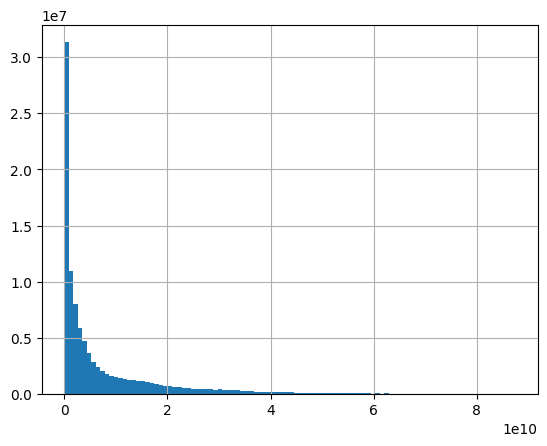

In [21]:
train_df['timestamp'].hist(bins = 100)

и гистограмму с максимальными временами в разрезе каждого пользователя:

array([[<Axes: title={'center': 'timestamp'}>]], dtype=object)

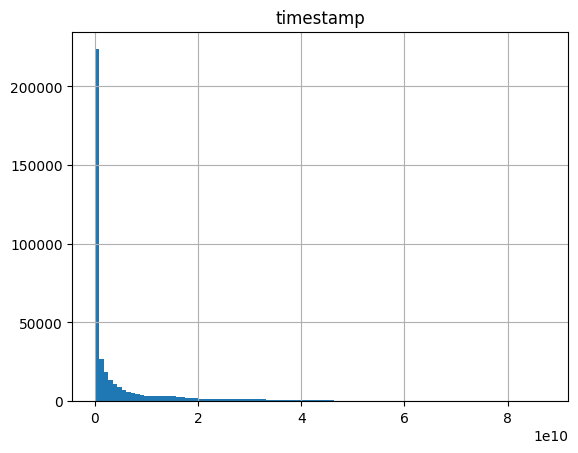

In [22]:
train_df.groupby('user_id').agg({'timestamp': 'max'}).hist(bins = 100)

Видим, что гистограммы имеют похожую структуру. Данные гистограммы показывают отток пользователей со временем. Из них видно, что большая часть пользователей не продолжаю оюучение на платформе. 
В зависимости от задачи, может потребовать более детально проанализировать этот параметр. Например, может потребоваться для конкретного пользователя проанализировать регулярность активностей.  

## 5.3. Распределение данных.

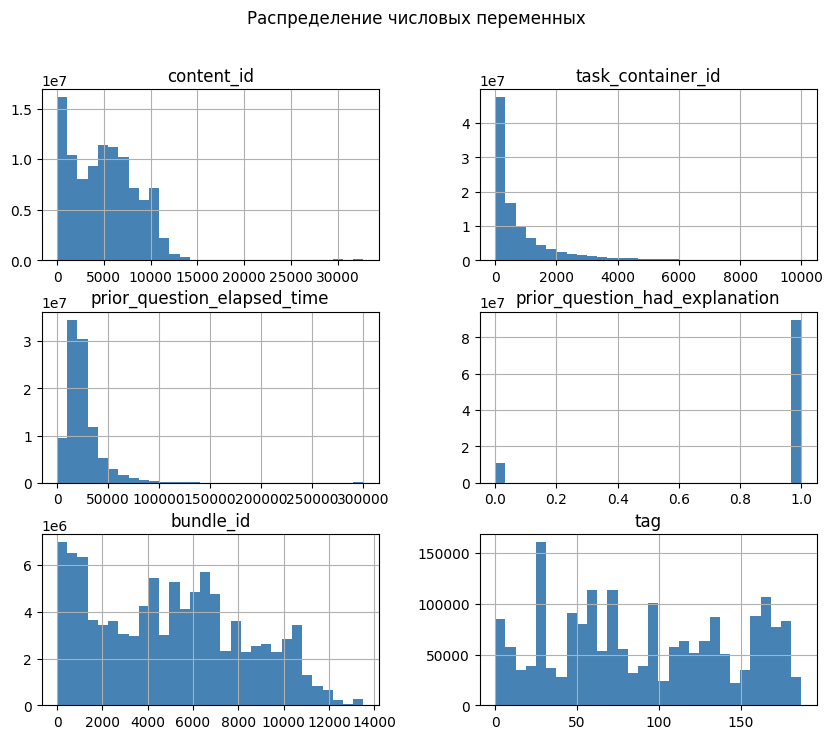

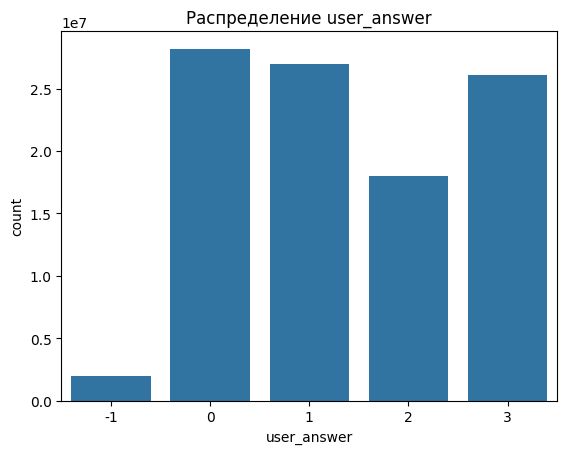

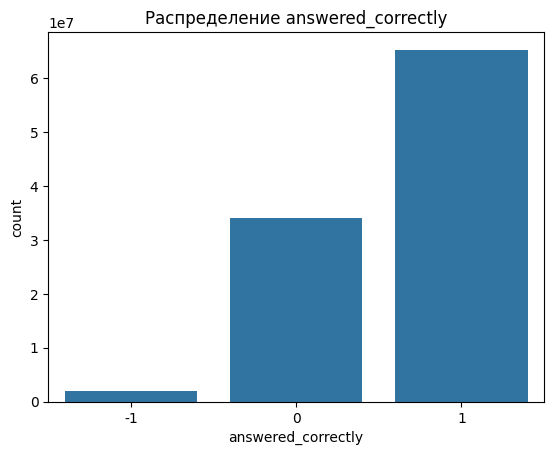

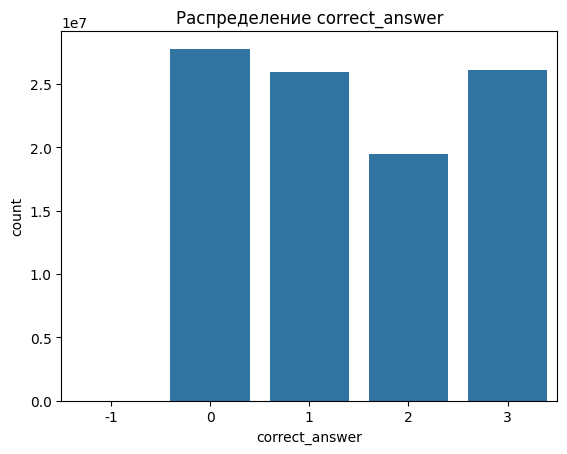

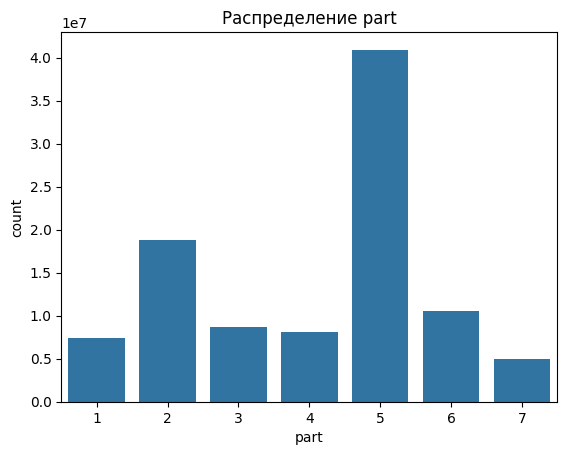

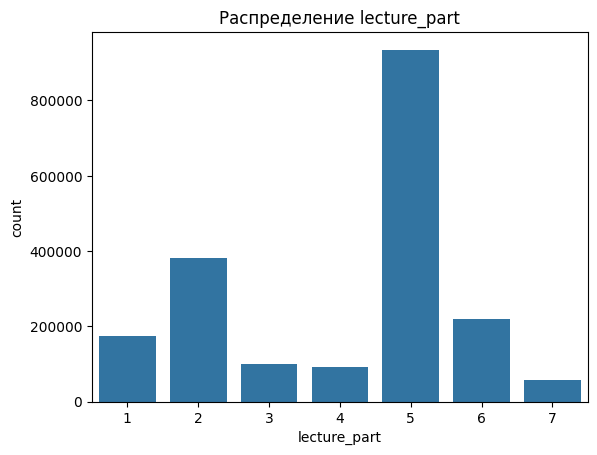

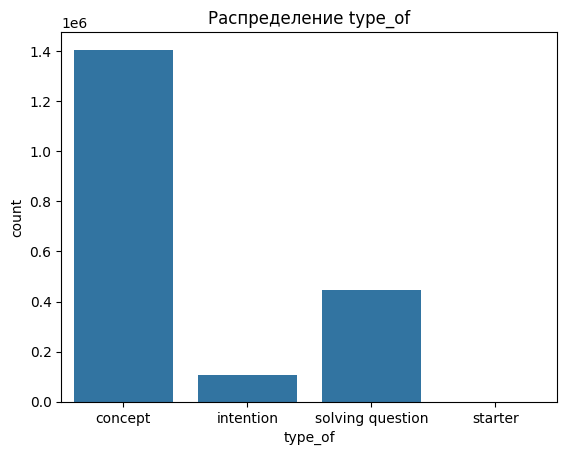

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
# Распределение числовых переменных, за исключением заведомо не интересных и timestamp с content_type_id
columns_to_exclude = ['row_id', 'timestamp', 'user_id', 'content_type_id'] 
train_union_filtered_df = train_union_df.drop(columns=columns_to_exclude)
train_union_filtered_df.hist(bins=30, figsize=(10, 8), color='steelblue')
plt.suptitle('Распределение числовых переменных')
plt.show()

# Распределение категориальных переменных
for column in ['user_answer', 'answered_correctly', 'correct_answer', 'part', 'lecture_part', 'type_of']:
    sns.countplot(x=column, data=train_union_df)
    plt.title(f'Распределение {column}')
    plt.show()
    

## 5.4. Выбросы значений.

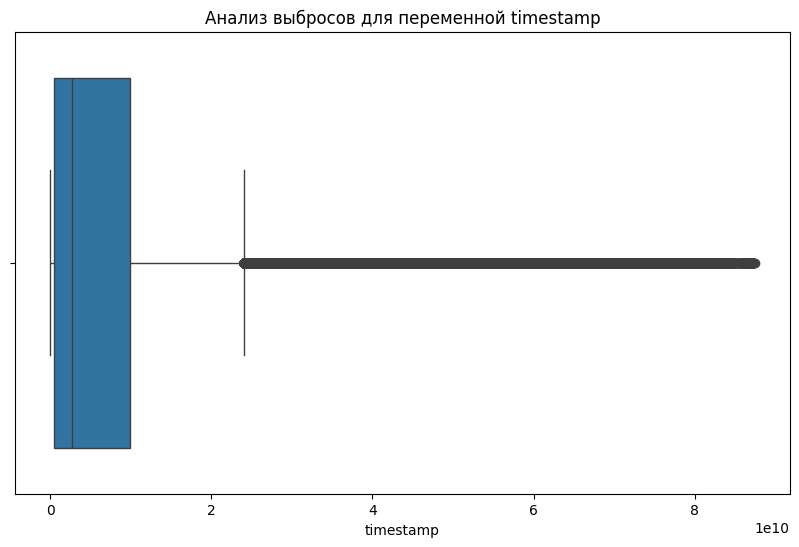

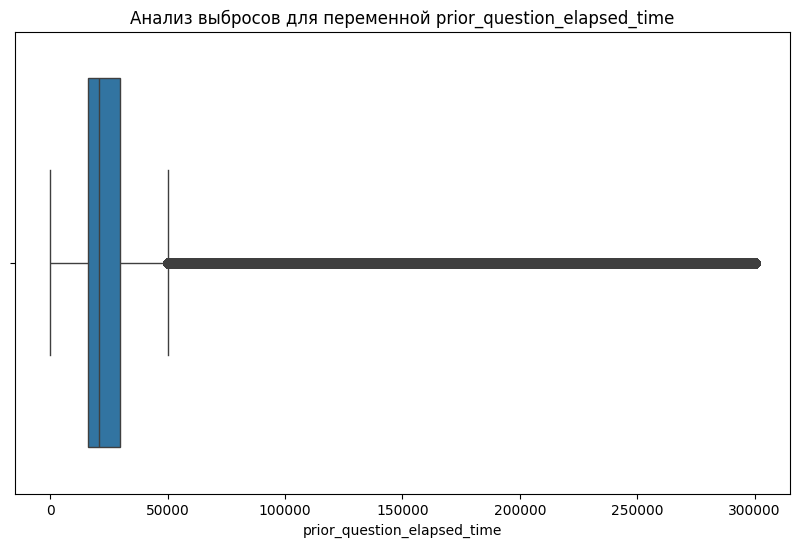

In [25]:
# Построение boxplot для столбцов с возможными выбросами:
for column in ['timestamp', 'prior_question_elapsed_time']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=train_union_df[column], orient='h')
    plt.title(f'Анализ выбросов для переменной {column}')
    plt.show()


## 5.6. Корреляционная матрица.

Исходя из прикладной области, кажется, что при анализе успеваемости, вероятнее потребуется в качестве целевой переменной понимать не ондиночные ответы, а агрегированные данные (среднее количество правильных ответов или общее количество правильных ответов). Поэтому для примера анализа зависимостей построим корреляционную матрицу для максимального времени подключения, среднего значения правильных ответов (answered_correctly) и общего значения правильных ответов:  

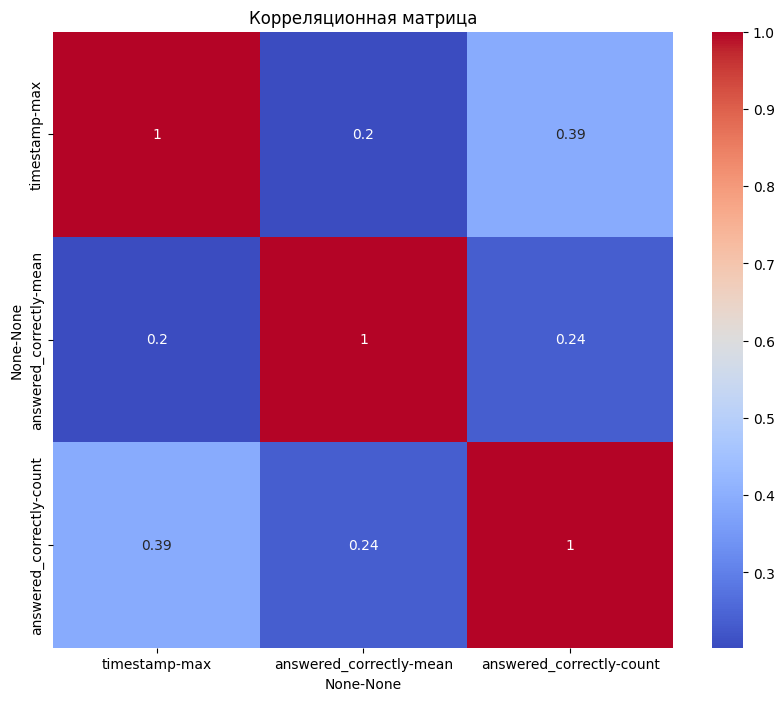

In [36]:
# Выбор интересующих нас признаков и целевой переменной
#колнки для исключения
columns_to_exclude = ['row_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 
    'prior_question_elapsed_time', 'prior_question_had_explanation', 'bundle_id',
    'correct_answer', 'part', 'tags', 'tag', 'lecture_part', 'type_of']
#удаляем колонки для исключения
train_union_filtered_df = train_union_df.drop(columns=columns_to_exclude)

#оставляем записи только для вопросов
train_union_filtered_df = train_union_filtered_df[train_union_filtered_df['answered_correctly']!=-1]

#для удобства приведём тип answered_correctly обратно к числовому 
train_union_filtered_df['answered_correctly'] = train_union_filtered_df['answered_correctly'].astype('int8')

#группируем данные по пользователю
grouped_by_user_df = train_union_filtered_df.groupby('user_id')

#получаем агрегированные данные
user_answers_df = grouped_by_user_df.agg({'timestamp': ['max'], 'answered_correctly': ['mean', 'count'] })

# Корреляционная матрица для числовых признаков
corr_matrix = user_answers_df.corr()

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()